## Verification strategies

- GOES
- Landsat

<a target="_blank" href="https://colab.research.google.com/github/contrailcirrus/2024-09-ge-workshop/blob/main/verification-strategies.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# Run in colab
!pip install pycontrails

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as dates
import numpy as np
import pandas as pd
import pyproj

from pycontrails import Flight, Fleet, DiskCacheStore
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.datalib import goes, landsat, sentinel
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ExponentialBoostLatitudeCorrectionHumidityScaling
from pycontrails.models.ps_model import PSFlight

In [2]:
BUCKET = "contrails-301217-2024-10-ge-workshop"
SOURCE = f"gs://{BUCKET}"
CACHE = DiskCacheStore(cache_dir="cache")

CONUS = (-125, -65, 22, 48)
DATE = pd.Timestamp("2019-02-01")

In [3]:
# Download flights from GCP
# This file has a few extra columns pre-computed
df = pd.read_parquet(f"{SOURCE}/flights/{DATE.strftime('%Y%m%d')}-full.pq")

## GOES imagery

Download full disk GOES imagery

In [4]:
# Time of interest in GOES imagery
time = pd.Timestamp("2019-02-01 18:00:00")

# Create GOES handler for full disk image with channels 11, 14, 15
handler = goes.GOES(region="F", channels=("C11", "C14", "C15"))

# Download the data
da = handler.get(time.to_pydatetime())

# Create GOES visualization
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

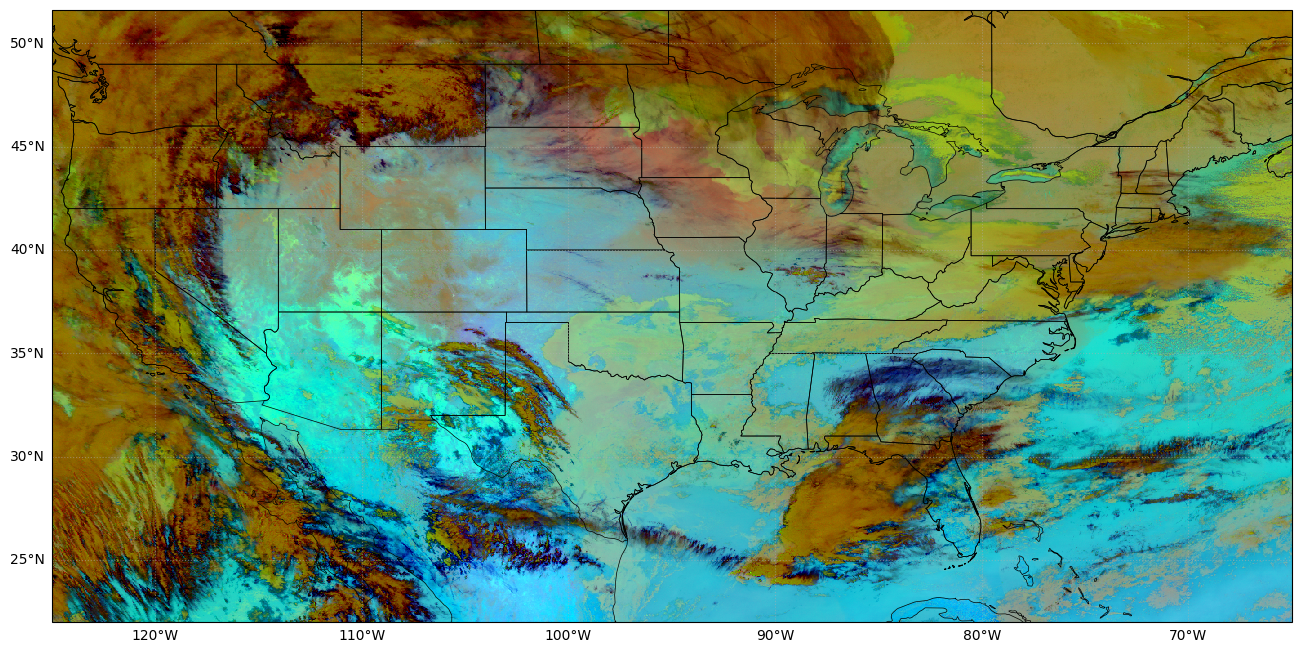

In [5]:
fig = plt.figure(figsize=(16, 8))

# PlateCaree projection over CONUS
ax = fig.add_subplot(projection=ccrs.PlateCarree(), extent=(-125, -65, 22, 48))

# add coastlines and state boundaries to plot
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

# Show GOES false color image
ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")

# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False; gl.right_labels = False;

### Compare CoCiP Run with GOES

> Make sure you have data caches from [pycontrails-basic](pycontrails-basics.ipynb) notebook.

In [6]:
time_bounds = (DATE, DATE + pd.Timedelta("36h"))
pressure_levels = (350, 300, 250, 225, 200, 175, 150)

era5pl = ERA5(
    time=time_bounds,
    variables=Cocip.met_variables,
    pressure_levels=pressure_levels,
    cachestore=CACHE
)
era5sl = ERA5(
    time=time_bounds, 
    variables=Cocip.rad_variables,
    cachestore=CACHE
)

met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

In [7]:
# Try 190201-35105-N736MB also!
flight = Flight(df[df["flight_id"] == "190201-90770-DAL2334"])
flight.attrs["aircraft_type"] = "A320"

params = {
    "dt_integration": np.timedelta64(10, "m"),
    # The humidity_scaling parameter is only used for ECMWF ERA5 data
    # See https://py.contrails.org/api/pycontrails.models.humidity_scaling.html#module-pycontrails.models.humidity_scaling
    "humidity_scaling": ExponentialBoostLatitudeCorrectionHumidityScaling(),
    # Use Poll-Schumann aircraft performance model adapted for grid calculations
    # See https://py.contrails.org/api/pycontrails.models.ps_model.PSGrid.html#pycontrails.models.ps_model.PSGrid
    "aircraft_performance": PSFlight(),
}
# Set up model
cocip = Cocip(met=met, rad=rad, params=params)
fl_cocip = cocip.eval(source=flight)

/Users/marcshapiro/computing/contrailcirrus/pycontrails/pycontrails/core/vector.py:118: UserWarning: Overwriting data in key `sac`. Use `.update(sac=...)` to suppress warning.
  warnings.warn(
/Users/marcshapiro/computing/contrailcirrus/pycontrails/pycontrails/core/vector.py:118: UserWarning: Overwriting data in key `T_critical_sac`. Use `.update(T_critical_sac=...)` to suppress warning.
  warnings.warn(


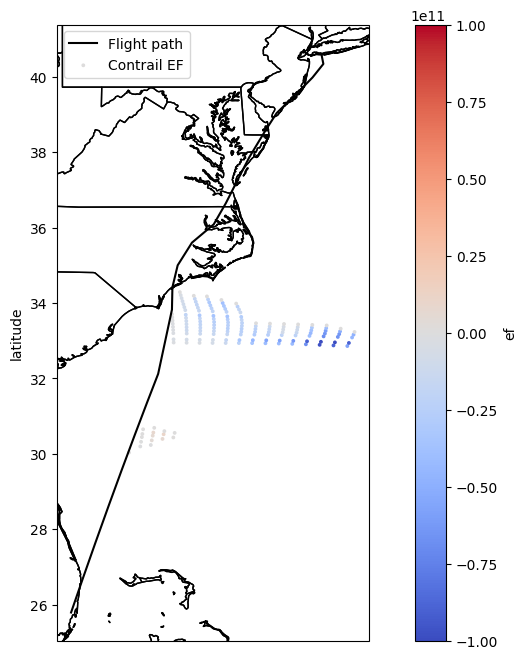

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.STATES)

flight.dataframe.plot(
    x="longitude",
    y="latitude",
    color="k",
    ax=ax,
    label="Flight path",
)
cocip.contrail.plot.scatter(
    x="longitude",
    y="latitude",
    c="ef",
    cmap="coolwarm",
    vmin=-1e11,
    vmax=1e11,
    ax=ax,
    s=3,
    label="Contrail EF",
)
ax.legend();

In [9]:
# Find time with large number of contrail segments
cocip.contrail.groupby("time")["flight_id"].count()

time
2019-02-01 18:20:00     1
2019-02-01 18:30:00     5
2019-02-01 18:40:00     5
2019-02-01 18:50:00    12
2019-02-01 19:00:00    18
2019-02-01 19:10:00    15
2019-02-01 19:20:00    15
2019-02-01 19:30:00    14
2019-02-01 19:40:00    13
2019-02-01 19:50:00     7
2019-02-01 20:00:00     7
2019-02-01 20:10:00     7
2019-02-01 20:20:00     7
2019-02-01 20:30:00     7
2019-02-01 20:40:00     7
2019-02-01 20:50:00     6
2019-02-01 21:00:00     5
Name: flight_id, dtype: int64

In [10]:
# Time of interest in GOES imagery
time = pd.Timestamp("2019-02-01 19:30:00")

# select contrail segments at this time
contrail = cocip.contrail[cocip.contrail["time"] == time]

# zoom extent on this region
extent = (
    contrail["longitude"].min() - 1,
    contrail["longitude"].max() + 1,
    contrail["latitude"].min() - 1,
    contrail["latitude"].max() + 1
)

# Create GOES handler for full disk image with channels 11, 14, 15
handler = goes.GOES(region="F", channels=("C11", "C14", "C15"))

# Download the data
da = handler.get(time.to_pydatetime())

# Create GOES visualization
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

In [11]:
# show contrail segment ages at this time
contrail["age"]

71   0 days 00:46:44
72   0 days 00:46:04
73   0 days 00:44:47
74   0 days 00:44:07
75   0 days 00:43:27
76   0 days 00:42:47
77   0 days 00:42:07
78   0 days 00:41:27
79   0 days 00:40:47
80   0 days 00:39:48
81   0 days 00:39:08
82   0 days 00:38:28
83   0 days 00:37:48
84   0 days 00:00:00
Name: age, dtype: timedelta64[ns]

In [ ]:
fig = plt.figure(figsize=(16, 8))

# PlateCaree projection over CONUS
ax = fig.add_subplot(projection=ccrs.PlateCarree(), extent=extent)

# add coastlines and state boundaries to plot
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

# Show GOES false color image
ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")

# Show contrail segments
contrail.plot.scatter(
    x="longitude", 
    y="latitude", 
    c="k",
    s=2,
    ax=ax,
    transform=ccrs.PlateCarree()
)

# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False; gl.right_labels = False;

## Compare with Landsat imagery

In [ ]:
# Find unique flight_id's that have waypoints with RHi > 1
df_issr = df[df["rhi"] > 1]
issr_flights = df_issr["flight_id"].unique()

In [ ]:
# Iterate to find flights in ISSR that have Landsat coverage
for fid in issr_flights:
    
    # Select flights with at least 2 waypoints in ISSR
    df_issr_flight = df_issr[df_issr["flight_id"] == fid]
    if len(df_issr_flight) < 2: 
        continue
    
    # Find landsat images that intersect with any of these flights
    scenes = landsat.intersect(
        Flight(data=df_issr_flight), 
        columns=["base_url", "sensing_time", "west_lon", "east_lon", "south_lat", "north_lat"]
    )

    # Stop iterating when we find a scene
    if len(scenes):
        print(f"Found scenes for flight: {fid}")
        break

In [ ]:
# Show scene with flight
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()

# plot flight
df_issr_flight.plot(x="longitude", y="latitude", ax=ax, transform=ccrs.PlateCarree(), legend=False)

# plot scene rectanglrs
for _, row in scenes.iterrows():
    x0 = row["west_lon"]
    y0 = row["south_lat"]
    w = row["east_lon"] - row["west_lon"]
    h = row["north_lat"] - row["south_lat"]
    plt.gca().add_patch(patches.Rectangle((x0, y0), w, h, ec="red", fc="none"))

#### Visualize a true-color scene

Bands 2, 3, and 4 can be used to create a true-color image.

In [ ]:
# Select scene data
scene = scenes.iloc[0]
base_url = scene["base_url"]
sensing_time = scene["sensing_time"]
sensing_time

In [ ]:
# Find waypoints in this scence
df_scene = df_issr_flight[
    df_issr_flight["longitude"].between(scene["west_lon"], scene["east_lon"]) &\
    df_issr_flight["latitude"].between(scene["south_lat"], scene["north_lat"]) &\
    df_issr_flight["time"].between(
        (sensing_time - pd.Timedelta("10m")).to_numpy(), 
        (sensing_time + pd.Timedelta("1m")).to_numpy()
    )
]

In [ ]:
# Plot the RHi of the waypoints in the scene
plt.plot(df_scene["time"], df_scene["rhi"], "k-", ms = 1)

mask = df_scene["rhi"] >= 1
plt.plot(df_scene["time"], np.where(mask, df_scene["rhi"], np.nan), "b-", label="ISSR")

mask = df_scene["sac"]  == 1
plt.plot(df_scene["time"], np.where(mask, df_scene["rhi"], np.nan), "r-", label="SAC")

mask = df_scene["rhi"] >= 1
plt.plot(df_scene["time"], np.where(mask, df_scene["rhi"], np.nan), "g-", label="PCR")

plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%m/%d\n%H:%M"))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time, color="gray", ls="--");
plt.legend(loc="upper right", frameon=False);

In [ ]:
# Download landsat data
handler = landsat.Landsat(base_url, bands=["B2", "B3", "B4", "B9", "B10", "B11"])
landsat_ds = handler.get()

# Create visualization
rgb, crs, extent = landsat.extract_landsat_visualization(landsat_ds, color_scheme="true")

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

In [ ]:
# interpolate flight location to satellite sensing time
flight_lon = np.interp(
    sensing_time.timestamp(),
    df_scene["time"].apply(lambda t: t.timestamp()),
    df_scene["longitude"],
)
flight_lat = np.interp(
    sensing_time.timestamp(),
    df_scene["time"].apply(lambda t: t.timestamp()),
    df_scene["latitude"],
)

# convert coordinates
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlim([flight_x - 5e3, flight_x + 5e3])
plt.ylim([flight_y - 5e3, flight_y + 5e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

### Look at SAC instead of ISSR

In [ ]:
# Find unique flight_id's that have waypoints with SAC == 1
df_sac = df[df["sac"] == 1]
sac_flights = df_sac["flight_id"].unique()

In [ ]:
# Iterate to find flights in ISSR that have Landsat coverage
for fid in sac_flights:
    
    # Select flights with at least 2 waypoints in ISSR
    df_sac_flight = df_sac[df_sac["flight_id"] == fid]
    if len(df_sac_flight) < 2: 
        continue
    
    # Find landsat images that intersect with any of these flights
    scenes = landsat.intersect(
        Flight(data=df_sac_flight), 
        columns=["base_url", "sensing_time", "west_lon", "east_lon", "south_lat", "north_lat"]
    )

    # Stop iterating when we find a scene
    if len(scenes):
        print(f"Found scenes for flight: {fid}")
        break

In [ ]:
# Show scene with flight
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()

# plot flight
df_sac_flight.plot(x="longitude", y="latitude", ax=ax, transform=ccrs.PlateCarree(), legend=False)

# plot scene rectanglrs
for _, row in scenes.iterrows():
    x0 = row["west_lon"]
    y0 = row["south_lat"]
    w = row["east_lon"] - row["west_lon"]
    h = row["north_lat"] - row["south_lat"]
    plt.gca().add_patch(patches.Rectangle((x0, y0), w, h, ec="red", fc="none"))

#### Visualize a true-color scene

Bands 2, 3, and 4 can be used to create a true-color image.

In [ ]:
# Select scene data
scene = scenes.iloc[0]
base_url = scene["base_url"]
sensing_time = scene["sensing_time"]
sensing_time

In [ ]:
# Find waypoints in this scence
df_scene = df_sac_flight[
    df_sac_flight["longitude"].between(scene["west_lon"], scene["east_lon"]) &\
    df_sac_flight["latitude"].between(scene["south_lat"], scene["north_lat"]) &\
    df_sac_flight["time"].between(
        (sensing_time - pd.Timedelta("10m")).to_numpy(), 
        (sensing_time + pd.Timedelta("1m")).to_numpy()
    )
]

In [ ]:
# Plot the RHi of the waypoints in the scene
plt.plot(df_scene["time"], df_scene["rhi"], "k-", ms = 1)

mask = df_scene["rhi"] >= 1
plt.plot(df_scene["time"], np.where(mask, df_scene["rhi"], np.nan), "b-", label="ISSR")

mask = df_scene["sac"]  == 1
plt.plot(df_scene["time"], np.where(mask, df_scene["rhi"], np.nan), "r-", label="SAC")

mask = df_scene["rhi"] >= 1
plt.plot(df_scene["time"], np.where(mask, df_scene["rhi"], np.nan), "g-", label="PCR")

plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%m/%d\n%H:%M"))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time, color="gray", ls="--");
plt.legend(loc="upper right", frameon=False);

In [ ]:
# Download landsat data
handler = landsat.Landsat(base_url, bands=["B2", "B3", "B4", "B9", "B10", "B11"])
landsat_ds = handler.get()

# Create visualization
rgb, crs, extent = landsat.extract_landsat_visualization(landsat_ds, color_scheme="true")

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

In [ ]:
# interpolate flight location to satellite sensing time
flight_lon = np.interp(
    sensing_time.timestamp(),
    df_scene["time"].apply(lambda t: t.timestamp()),
    df_scene["longitude"],
)
flight_lat = np.interp(
    sensing_time.timestamp(),
    df_scene["time"].apply(lambda t: t.timestamp()),
    df_scene["latitude"],
)

# convert coordinates
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlim([flight_x - 5e3, flight_x + 5e3])
plt.ylim([flight_y - 5e3, flight_y + 5e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)");